In [93]:
# Install:
# pandas, openpyxl, numpy, scikit-learn, matplotlib
# plotly, nbformat

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression

# Python academy

In [95]:
df = pd.read_excel('podatki_python_akademija.xlsx')

In [96]:
df.columns

Index(['ID', 'DAN', 'LETO', 'DAN_V_TEDNU', 'TEDEN', 'DAN_V_MESECU', 'DATUM',
       'PRA_DAN', 'PRA_PRED', 'PRA_NASL', 'PRA', 'BDP1', 'BDP2', 'BDP3',
       'URA_VEC', 'URA_MANJ', 'MIN_VREDNOST', 'MAX_VREDNOST', 'STEVEC',
       'MIN_PRET_TED', 'MAX_PRET_TED', 'TEMP_MIN', 'TEMP_MAX', 'MIN_VRED_LM1',
       'MAX_VRED_LM1', 'PMIN_VRED_LM1', 'PMAX_VRED_LM1', 'RPMIN_VRED_LM1',
       'RPMAX_VRED_LM1'],
      dtype='object')

## Linear regression (3.-4.)

In [97]:
X = df["MAX_PRET_TED"].values.reshape(-1, 1)
Y = df["MAX_VREDNOST"].values # .reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

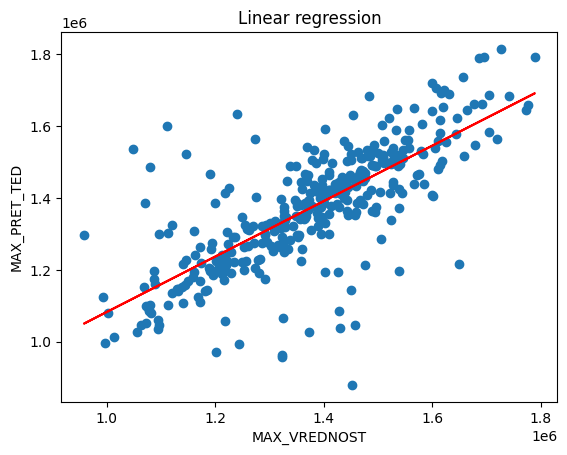

In [98]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.title("Linear regression")
plt.xlabel("MAX_VREDNOST")
plt.ylabel("MAX_PRET_TED")
plt.show()

## Multiple linear regression (5.-6.)

In [99]:
X = df.drop(["ID", "DAN", "LETO", "DAN_V_TEDNU", "TEDEN", "DAN_V_MESECU", "DATUM", "STEVEC", "MIN_VREDNOST"], axis=1).values
Y = df["MAX_VREDNOST"].values
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

## BIC (7.)
Idea:
- Start by defining a set of candidate models. Each model in the set should include a different combination of predictor variables. For example, if you have 5 predictor variables, you could define a set of models that includes all possible combinations of those 5 variables (i.e., $2^5 - 1 = 31$ models).  
Our case: 20 vairables means $2^20 - 1 = 1048575$ models
- For each model in the set, estimate the multiple linear regression coefficients using your dataset.
- Compute the BIC value for each model using the following formula:  
$BIC = n * ln(RSS/n) + k * ln(n)$

This takes too much time, so we perform PCA instead and see, that 4 variables are more than sufficient for model explainability (98.46%).  
We then perform the idea above on up to 4 variable combinations.

In [101]:
# Prepare data
X = df.drop(["ID", "DAN", "LETO", "DAN_V_TEDNU", "TEDEN", "DAN_V_MESECU", "DATUM", "STEVEC", "MIN_VREDNOST", "MAX_VREDNOST"], axis=1)
Y = df["MAX_VREDNOST"]

In [308]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
rss = np.sum((Y - Y_pred)**2)
n = len(Y) # + 1.e-10
k = len(X) + 1 # add 1 for the intercept term
bic = n * np.log(rss/n) + k * np.log(n)
print(bic)
linear_regressor.coef_ # Coefficients for set of all variables

9974.455883906601


array([-2.79554164e+05, -7.75089144e+04, -3.12791412e+04,  4.11414921e+03,
        1.67620342e+02,  6.07611754e+03,  1.70860705e+04,  1.71737794e+05,
       -4.99170243e+03,  1.83749752e-01,  6.62245100e-02, -1.56068389e+03,
       -4.05792381e+03, -2.67684172e-02,  1.91102168e-01, -1.68302534e-01,
        7.94720916e-01, -1.42520297e-01, -4.35530139e-02])

In [305]:
from sklearn.decomposition import PCA
import plotly.express as px

# PCA
pca = PCA()
pca.fit(X)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [307]:
exp_var_cumul # explained variance by the number of components

array([0.82485661, 0.90210902, 0.95140523, 0.98460843, 0.99418678,
       0.9984509 , 0.99961983, 0.99999984, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [300]:
%%time
# Checks all possibilites for model parameters up to 4 variables
# Total combinations: 2^4 - 1 = 18
from itertools import combinations

# define candidate models
variables = X.columns
models = []
max_variables = 6 # Hardcode number of variables tested
for i in range(1, max_variables + 1):
    combos = combinations(variables, i)
    for combo in combos:
        models.append(list(combo))
        
bic_values = []
for model in models:
    X_subset = X[model]
    reg = LinearRegression().fit(X_subset, Y)
    rss = np.sum((Y - reg.predict(X_subset))**2)
    num_examples = len(Y) # + 1.e-10
    num_params = len(model) + 1 # add 1 for the intercept term
    bic = num_examples * np.log(rss/n) + num_params * np.log(n)
    bic_values.append(bic)

CPU times: user 1min 4s, sys: 221 ms, total: 1min 4s
Wall time: 1min 4s


In [301]:
best_model_idx = np.argmin(bic_values)
best_model = models[best_model_idx]
print(f"Best model (by BIC): {best_model} with BIC value {bic_values[best_model_idx]:.2f}")

Best model (by BIC): ['PRA_DAN', 'PRA_PRED', 'BDP1', 'MAX_PRET_TED', 'TEMP_MAX', 'PMAX_VRED_LM1'] with BIC value 7948.91


In [309]:
# Retrain linear regressor again with the best model to get coefficients
linear_regressor = LinearRegression()
linear_regressor.fit(X[best_model], Y)
Y_pred = linear_regressor.predict(X[best_model])
coefficients = np.round(linear_regressor.coef_, 3) # round coefficients

result_tuples = list(zip(best_model, coefficients)) # Zip coefficients with names
result_tuple = pd.DataFrame(result_tuples, columns=["variable", "coefficient"]).T
result_tuple.to_csv('out/Rezultat.csv', index=False, header=False) # Write result to CSV
result_tuple

,0,1,2,3,4,5
variable,PRA_DAN,PRA_PRED,BDP1,MAX_PRET_TED,TEMP_MAX,PMAX_VRED_LM1
coefficient,-284973.937,-76115.756,94.551,0.157,-4135.516,0.789


## 8. MAE, MAPE, SMAPE in RMSE

In [310]:
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(Y_pred - Y))
print("MAE:", mae)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y - Y_pred) / Y)) * 100
print("MAPE:", mape)

# Symmetric Mean Absolute Percentage Error (SMAPE)
smape = np.mean(np.abs(Y - Y_pred) / ((np.abs(Y) + np.abs(Y_pred)) / 2)) * 100
print("SMAPE:", smape)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((Y_pred - Y)**2))
print("RMSE:", rmse)

MAE: 46654.440309214224
MAPE: 3.417058572992098
SMAPE: 3.422192296288244
RMSE: 60691.10564659926


## 9.-11. MAE, MAPE, SMAPE in RMSE function

In [464]:
def calculate_errors(df, col_measured: str, col_predicted: str):
    if df is None or not col_measured or not col_predicted:
        raise Exception("Provide correct input data (df, col_measured, col_predicted)!") 
    
    Y = df[col_measured]
    Y_pred = df[col_predicted]
    
    mae = round(np.mean(np.abs(Y_pred - Y)), 2)
    print("MAE:", mae)

    # Mean Absolute Percentage Error (MAPE)
    mape = round(np.mean(np.abs((Y - Y_pred) / Y)) * 100, 2)
    print("MAPE:", mape)

    # Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = round(np.mean(np.abs(Y - Y_pred) / ((np.abs(Y) + np.abs(Y_pred)) / 2)) * 100, 2)
    print("SMAPE:", smape)

    # Root Mean Squared Error (RMSE)
    rmse = round(np.sqrt(np.mean((Y_pred - Y)**2)), 2)
    print("RMSE:", rmse)
    
    return {"mae": mae, "mape": mape, "smape": smape, "rmse": rmse}

In [312]:
# preare data for calculate_errors function
Y_zipped = list(zip(Y, np.round(Y_pred, 2)))
Y_data = pd.DataFrame(Y_zipped, columns=["measured", "predicted"]) # create 2-column df from tuples

In [313]:
import json

errors = calculate_errors(Y_data, "measured", "predicted")

with open('out/Rezultat.csv', 'a') as f:
    f.write(json.dumps(errors))
    f.write("\n")

MAE: 46654.44
MAPE: 3.42
SMAPE: 3.42


## 12. Train - test (MLR - Multiple Linear Regression)
Not sure if i'm supposed to drop columns here or not, like before, since the instructions don't specify it explicitly. 

I figured I need to do so, since other data looks redundant + I can reuse the knowledge about the best (BIC) model from before.

In [379]:
# Split data on train and test set
X_train = df[df["DATUM"].dt.month < 12] # jan-nov
X_test = df[df["DATUM"].dt.month == 12] # december

Y_train = X_train["MAX_VREDNOST"]
Y_test = X_test["MAX_VREDNOST"]

# Get "best model" features from Rezultat.csv
best_feature_names = list(pd.read_csv("out/Rezultat.csv", nrows=0).columns)

X_train = X_train[best_feature_names]
X_test = X_test[best_feature_names]

In [465]:
# Train the models and predict on train and test data using MLR
linear_regressor = LinearRegression().fit(X_train, Y_train)
Y_pred = np.round(linear_regressor.predict(X_train), 2)
Y_test_pred = np.round(linear_regressor.predict(X_test), 2)

# Preare data for calculate_errors function
Y_train_data = pd.DataFrame(list(zip(Y_train, Y_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples
Y_test_data = pd.DataFrame(list(zip(Y_test, Y_test_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples

# Calculate errors
errors_train = calculate_errors(Y_train_data, "measured", "predicted")
print()
errors_test = calculate_errors(Y_test_data, "measured", "predicted")

# Write results to file
with open('out/NapakeUcnoTestno.csv', 'w') as f:
    f.write(json.dumps(errors_train))
    f.write("\n")
    f.write(json.dumps(errors_test))
    f.write("\n")

MAE: 46454.52
MAPE: 3.4
SMAPE: 3.41
RMSE: 60460.74

MAE: 48944.79
MAPE: 3.57
SMAPE: 3.52
RMSE: 64282.83


## 13. Train - test (SVM)

In [484]:
from sklearn.svm import SVR

# Train the models and predict on train and test data using SVM
svr = SVR(kernel="poly") # kernels: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
svr.fit(X_train, Y_train)
Y_pred = np.round(svr.predict(X_train), 2)
Y_test_pred = np.round(svr.predict(X_test), 2)

In [485]:
# Preare data for calculate_errors function
Y_train_data = pd.DataFrame(list(zip(Y_train, Y_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples
Y_test_data = pd.DataFrame(list(zip(Y_test, Y_test_pred)), columns=["measured", "predicted"]) # create 2-column df from tuples

# Calculate errors
errors_train = calculate_errors(Y_train_data, "measured", "predicted")
print()
errors_test = calculate_errors(Y_test_data, "measured", "predicted")

# Write results to file
with open('out/SVM_napake.csv', 'w') as f:
    f.write(json.dumps(errors_train))
    f.write("\n")
    f.write(json.dumps(errors_test))
    f.write("\n")

MAE: 133087.74
MAPE: 10.27
SMAPE: 9.85
RMSE: 167738.97

MAE: 157593.53
MAPE: 11.0
SMAPE: 11.11
RMSE: 187562.12


### Linear
MAE: 424130.09
MAPE: 29.37
SMAPE: 36.88
RMSE: 513601.52

MAE: 647371.17
MAPE: 43.82
SMAPE: 58.21
RMSE: 700468.09

### Poly
MAE: 133087.74
MAPE: 10.27
SMAPE: 9.85
RMSE: 167738.97

MAE: 157593.53
MAPE: 11.0
SMAPE: 11.11
RMSE: 187562.12

### RBF
MAE: 133139.38
MAPE: 10.28
SMAPE: 9.86
RMSE: 167802.86

MAE: 157632.14
MAPE: 11.0
SMAPE: 11.11
RMSE: 187615.37

### Sigmoid
MAE: 133145.73
MAPE: 10.28
SMAPE: 9.86
RMSE: 167810.76

MAE: 157636.23
MAPE: 11.0
SMAPE: 11.11
RMSE: 187620.83

In [503]:
print("MLR Errors")
with open('out/NapakeUcnoTestno.csv') as f:
    data = f.read()
    print(data)

print("SVM Errors")
with open('out/SVM_napake.csv') as f:
    data = f.read()
    print(data)
    
# Better model is the one with lower error rates (my case: MLR model)

MLR Errors
{"mae": 46454.52, "mape": 3.4, "smape": 3.41, "rmse": 60460.74}
{"mae": 48944.79, "mape": 3.57, "smape": 3.52, "rmse": 64282.83}

SVM Errors
{"mae": 133087.74, "mape": 10.27, "smape": 9.85, "rmse": 167738.97}
{"mae": 157593.53, "mape": 11.0, "smape": 11.11, "rmse": 187562.12}

